# Exploratory data analysis¶

In [1]:
# Load Packages
import pandas as pd
import altair as alt 
import matplotlib as plt
from sklearn.model_selection import train_test_split
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [2]:
def mds_special():
    font = "Arial"
    axisColor = "#000000"
    gridColor = "#DEDDDD"
    return {
        "config": {
            "title": {
                "fontSize": 24,
                "font": font,
                "anchor": "start", # equivalent of left-aligned.
                "fontColor": "#000000"
            },
            "header": {
                "fontSize": 14,
                "labelFontSize": 14
            },

            'view': {
                "height": 300, 
                "width": 400
            },
            "axisX": {
                "domain": True,
                #"domainColor": axisColor,
                "gridColor": gridColor,
                "domainWidth": 1,
                "grid": False,
                "labelFont": font,
                "labelFontSize": 14,
                "labelAngle": 0, 
                "tickColor": axisColor,
                "tickSize": 5, # default, including it just to show you can change it
                "titleFont": font,
                "titleFontSize": 16,
                "titlePadding": 10, # guessing, not specified in styleguide
                "title": "X Axis Title (units)", 
            },
            "axisY": {
                "domain": False,
                "grid": True,
                "gridColor": gridColor,
                "gridWidth": 1,
                "labelFont": font,
                "labelFontSize": 14,
                "labelAngle": 0, 
                #"ticks": False, # even if you don't have a "domain" you need to turn these off.
                "titleFont": font,
                "titleFontSize": 16,
                "titlePadding": 10, # guessing, not specified in styleguide
                "title": "Y Axis Title (units)", 
                # titles are by default vertical left of axis so we need to hack this 
                #"titleAngle": 0, # horizontal
                #"titleY": -10, # move it up
                #"titleX": 18, # move it to the right so it aligns with the labels 
            },
        }
            }

# register the custom theme under a chosen name
alt.themes.register('mds_special', mds_special)

# enable the newly registered theme
alt.themes.enable('mds_special')
#alt.themes.enable('none') # to return to default

ThemeRegistry.enable('mds_special')

## 1. Describe the dataset

## 2. Load the dataset 

In [3]:
# Load the dataset 
# breast_quad: the quadrant of the breast
df = pd.read_csv("../data/raw_data/breast_cancer_raw.csv")
df.columns = ["Class", "age", "menopause", "tumor_size", "inv_nodes", "node_caps", "deg_malig", "breast", "breast_quad", "irradiat"]

In [4]:
df.head()

,Class,age,menopause,tumor_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irradiat
0,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
1,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
2,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,left,left_low,no
4,no-recurrence-events,50-59,premeno,25-29,0-2,no,2,left,left_low,no


## 3. Explore the dataset 

In [5]:
print("- There are two classes of breast cancer: ", list(df["Class"].dropna().unique()), "\n")
print("- The groups of age are: ", sorted(list(df["age"].dropna().unique())), "\n")
print("- The menopause times are: ", list(df["menopause"].dropna().unique()), "\n")
print("- The groups of patients' tumor size are:", list(df["tumor_size"].dropna().unique()), "\n") 
print("- The ranges of the number of axillary lymph nodes that contain metastatic breast cancer visible on histological examinationare are: "\
      , list(df["inv_nodes"].dropna().unique()), "\n")
print("- The degree of malignancy ranging form {0}-{1}".format(df["deg_malig"].dropna().min(), df["deg_malig"].max()), "\n") 
print("- There are {0} patient's node is present in cap of the breast out of {1}".format(df[df["node_caps"] == 'yes']["node_caps"].count(), df["node_caps"].count()), "\n") 
print("- The quadrants of the breast are: ", list(df["breast_quad"].dropna().unique()), "\n")
print("- There are {0} patients are used to be treated with radiation therapy while {1} patients are not".format(df[df["irradiat"] == 'yes']["irradiat"].count(), df[df["irradiat"] == 'no']["irradiat"].count()), "\n") 

# deg_malig: Degree of malignancy
# inv_nodes: the number (range 0 - 39) of axillary lymph nodes that contain metastatic breast cancer visible on histological examination
# node_caps: if the cancer does metastasise to a lymph node, although outside the original site of the tumor it may remain “contained” 
#           by the capsule of the lymph node. However, over time, and with more aggressive disease, the tumor may replace the lymph node 
#           and then penetrate the capsule, allowing it to invade the surrounding tissues;

- There are two classes of breast cancer:  ['no-recurrence-events', 'recurrence-events'] 

- The groups of age are:  ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79'] 

- The menopause times are:  ['premeno', 'ge40', 'lt40'] 

- The groups of patients' tumor size are: ['20-24', '15-19', '0-4', '25-29', '50-54', '10-14', '30-34', '40-44', '35-39', '5-9', '45-49'] 

- The ranges of the number of axillary lymph nodes that contain metastatic breast cancer visible on histological examinationare are:  ['0-2', '6-8', '9-11', '3-5', '15-17', '12-14', '24-26'] 

- The degree of malignancy ranging form 1-3 

- There are 56 patient's node is present in cap of the breast out of 284 

- The quadrants of the breast are:  ['left_low', 'left_up', 'right_low', 'central', 'right_up', '?'] 

- There are 68 patients are used to be treated with radiation therapy while 216 patients are not 



## 4. Wrangling

In [6]:
df = df.query("node_caps != '?' and breast_quad != '?'")
# Average the tumor size
tumor_size_str_lst = [i.split('-', 1) for i in list(df["tumor_size"])]
tumor_size_int_lst = []
tumor_size_avg_lst = []
for i in range(len(tumor_size_str_lst)):
    tumor_size_int_lst.append([int(j) for j in tumor_size_str_lst[i]])
for i in range(len(tumor_size_int_lst)):
    tumor_size_avg_lst.append(sum(tumor_size_int_lst[i])/len(tumor_size_int_lst[i]))
df["avg_tumor_size"] = tumor_size_avg_lst
df = df.drop(columns = ["tumor_size"])

In [7]:
df.to_csv("../data/clean_data/breast_cancer_clean.csv", index=False)
# Split data 
df_train, df_test = train_test_split(df, test_size=0.20, random_state=100)

In [8]:
df_train.head()

,Class,age,menopause,inv_nodes,node_caps,deg_malig,breast,breast_quad,irradiat,avg_tumor_size
111,no-recurrence-events,40-49,premeno,0-2,no,1,right,left_up,no,12.0
230,recurrence-events,30-39,premeno,3-5,no,3,right,left_up,yes,32.0
29,no-recurrence-events,50-59,premeno,0-2,no,2,right,left_low,no,17.0
99,no-recurrence-events,50-59,ge40,0-2,no,3,right,left_low,no,32.0
216,recurrence-events,60-69,ge40,0-2,no,3,right,central,no,32.0


## 5. Data Analysis & Visualizations

In [9]:
df_train.info() # no missing values 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 111 to 8
Data columns (total 10 columns):
Class             220 non-null object
age               220 non-null object
menopause         220 non-null object
inv_nodes         220 non-null object
node_caps         220 non-null object
deg_malig         220 non-null int64
breast            220 non-null object
breast_quad       220 non-null object
irradiat          220 non-null object
avg_tumor_size    220 non-null float64
dtypes: float64(1), int64(1), object(8)
memory usage: 18.9+ KB


In [10]:
# Plot1: no-recurrence-events VS recurrence-events
plt1 = alt.Chart(df_train).mark_bar().encode(
    alt.X("Class:N"),
    alt.Y("count()", title = "Number of patients"),
).properties(width=300, height=200, title = "no-recurrence-events VS recurrence-events")

In [11]:
def plot_categorical(feature_name, title_name):
    plt = alt.Chart(df_train).mark_bar().encode(
        alt.X("Class", type ='ordinal', axis = alt.Axis(labelAngle = 45)),
        alt.Y("count()", title = "Number of patients"),
        alt.Column(feature_name)
    ).properties(width=100, height=200, title = title_name)
    
    return plt
    
    

In [12]:
plt2 = plot_categorical("menopause", "Recurrence class against patient's menopause")
plt3 = plot_categorical("age", "Recurrence class against patient's age")
plt4 = plot_categorical("node_caps", "Recurrence class against patient's node_caps")
plt5 = plot_categorical("deg_malig", "Recurrence class against patient's deg_malig")
plt5 = plot_categorical("breast_quad", "Recurrence class against patient's breast_quad")
plt6 = plot_categorical("irradiat", "Recurrence class against patient's irradiat treatment")
 

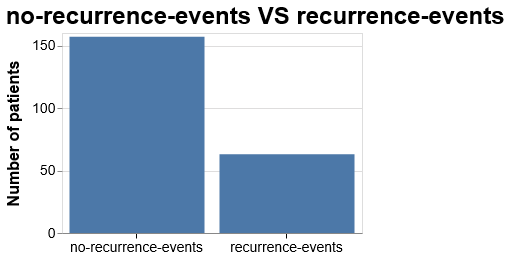

In [13]:
plt1

> Most breast cancer are non-current. The occurrence of no recurrent events is approximately as three times as many then the occurrence of recurrent events. The dataset is unbalance.

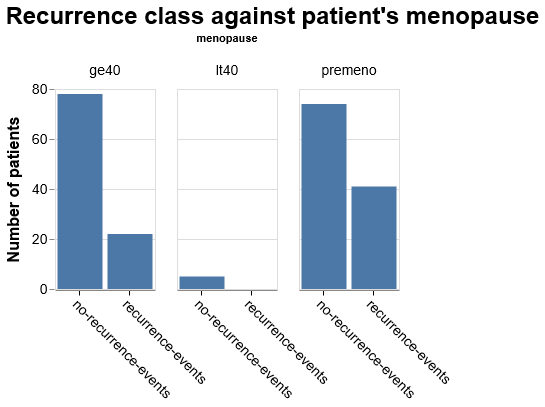

In [14]:
plt2

> People with age less than 40 almost don't have breast cancer. There are more recurrence events happening in premeno women.

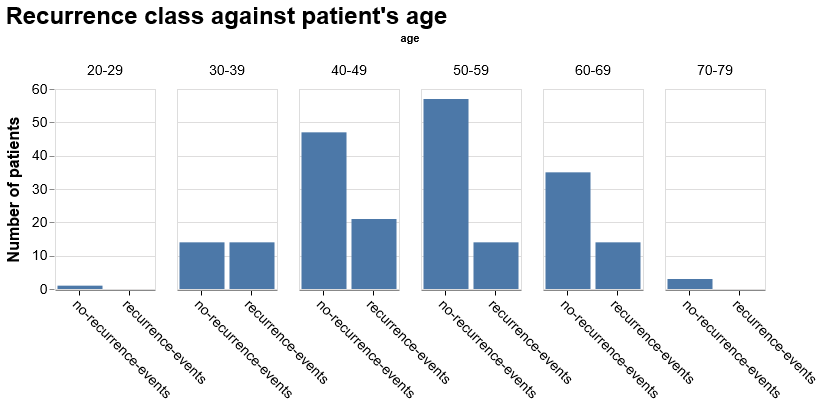

In [15]:
plt3

> People ranging from 50-59 are more likely to have breast cancers and their breast cancers are more likely to be non-recurrent.

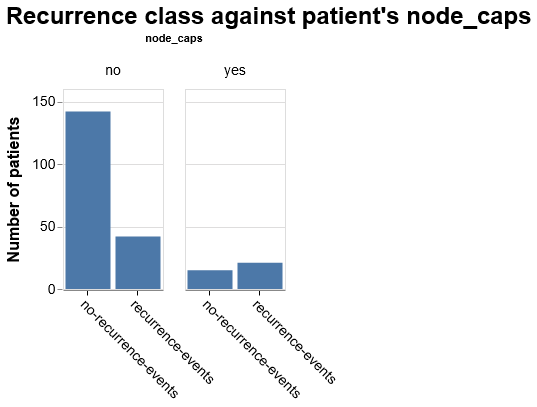

In [16]:
plt4

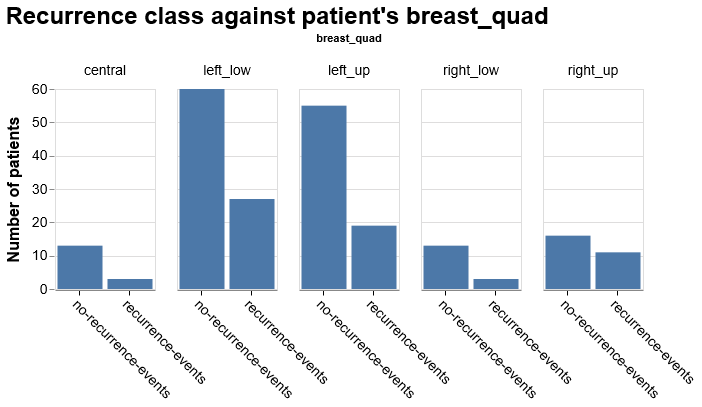

In [17]:
plt5

> Cancers are more likely to grow on left low and left up position while they are least likely to grow an the central position. Position seems to do nothing with the whether recurrence or not.

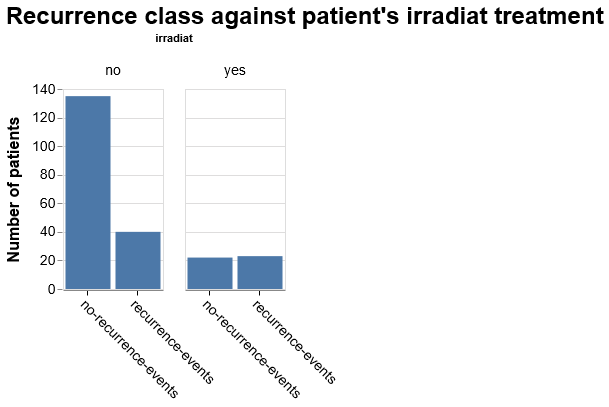

In [18]:
plt6

> Patients who have taken radiation therapy are more likely to have no recurrence events while patients who have not taken radiation therapy are more likely to have recurrence events.

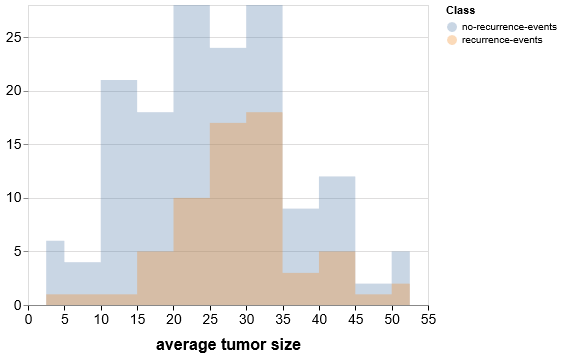

In [19]:
alt.Chart(df_train).mark_area(
    opacity=0.3,
    interpolate='step',
).encode(
    alt.X("avg_tumor_size:Q", bin=alt.Bin(), title = "average tumor size"),
    alt.Y('count()', stack=None),
    alt.Color('Class')
)

> The distribution of average tumor size is approximately normally distributed. Patients who have tumor with average size between 20-25 is more likely to be non-recurrent.